In [1]:
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.io 
import os
from datetime import datetime, timedelta
from deepface.commons import functions

In [2]:
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    if datenum < 600000:
        return 0
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
    
    return exact_date.year


In [3]:
def load_info(folder_path = "Train Image/imdb_crop"):
    mat = scipy.io.loadmat(os.path.join(folder_path, 'imdb.mat'))

    full_path = mat['imdb']['full_path'][0, 0][0]
    dob = mat['imdb']['dob'][0, 0][0]
    gender = mat['imdb']['gender'][0, 0][0]
    photo_taken = mat['imdb']['photo_taken'][0, 0][0]
    face_score = mat['imdb']['face_score'][0, 0][0]
    second_face_score = mat['imdb']['second_face_score'][0, 0][0]
    face_location = mat['imdb']['face_location'][0, 0][0]

    # Create a pandas dataframe to store the extracted data
    infos = pd.DataFrame({'full_path': full_path,
                        'dob': dob,
                        'gender': gender,
                        'photo_taken': photo_taken,
                        'face_score': face_score,
                        'second_face_score': second_face_score,
                        'face_location': face_location})
    infos['date_of_birth'] = infos['dob'].apply(datenum_to_datetime)
    infos['age'] = infos['photo_taken'] - infos['date_of_birth']
    return infos
infos = load_info()

In [4]:
#remove pictures does not include face
infos = infos[infos['face_score'] != -np.inf]
#some pictures include more than one face, remove them
infos = infos[infos['second_face_score'].isna()]
#some records do not have a gender information
infos = infos[~infos['gender'].isna()] 
infos = infos.drop(columns = ['face_score','second_face_score','dob','face_location', 'photo_taken', 'date_of_birth'])
# #drop fake age
indexAge = infos[(infos['age']<0)|(infos['age']>100)].index
infos.drop(indexAge, inplace = True)
infos.describe()

,gender,age
count,181482.000000,181482.000000
mean,0.550534,36.934473
std,0.497441,13.013128
min,0.000000,0.000000
25%,0.000000,28.000000
50%,1.000000,35.000000
75%,1.000000,44.000000
max,1.000000,99.000000


In [5]:
infos = infos.sort_values(by=["full_path"])
infos

,full_path,gender,age
4012,[00/nm0000100_rm1001569280_1955-1-6_2011.jpg],1.0,56
4013,[00/nm0000100_rm1002674432_1955-1-6_2003.jpg],1.0,48
4014,[00/nm0000100_rm1018346496_1955-1-6_2011.jpg],1.0,56
4015,[00/nm0000100_rm1019451648_1955-1-6_2003.jpg],1.0,48
4018,[00/nm0000100_rm1036228864_1955-1-6_2003.jpg],1.0,48
...,...,...,...
370740,[99/nm3361199_rm767405312_1990-3-26_2011.jpg],0.0,21
370741,[99/nm3361199_rm775597568_1990-3-26_2011.jpg],0.0,21
370744,[99/nm3361199_rm876260864_1990-3-26_2011.jpg],0.0,21
370746,[99/nm3361199_rm993701376_1990-3-26_2011.jpg],0.0,21


In [6]:
full_path = np.concatenate(infos['full_path'].to_numpy())
full_age = infos['age'].to_numpy()
full_gender = infos['gender'].to_numpy()

In [2]:
histogram_age = infos['age'].hist(bins=infos['age'].nunique())


KeyboardInterrupt



In [8]:
def load_image_data(folder_start = 0, folder_end = 1, folder_path = "Train Image/imdb_crop"):
    folder_range = [f"{i:02}" for i in range(folder_start, folder_end + 1)]
    filtered_path = np.array([s for s in full_path if s.split('/')[0] in folder_range])
    
    index = np.where(filtered_path[0])[0][0]
    
    images = []
    ages = []
    genders= []
    
    for file_path in filtered_path:
        # image = functions.extract_faces(os.path.join(folder_path, file_path), target_size = (160, 160), enforce_detection=False, grayscale=False, align=False, detector_backend="mediapipe")
        # image = np.squeeze(np.uint8((image[0][0])*255))
        # image = cv2.resize(image, (160, 160))
        # plt.imsave(os.path.join(folder_path, file_path), image)
        image = cv2.resize(cv2.imread(os.path.join(folder_path, file_path)), (160, 160))
        images.append(image)
        ages.append(full_age[index])
        genders.append(full_gender[index])
        index += 1
    images = np.array(images)
    ages = np.array(ages)
    genders = np.array(genders)
    
    return images, genders, ages
images_1, genders_1, ages_1 = load_image_data(0, 1)   
del infos
del full_age
del full_gender     
del full_path 

In [2]:
def load_utk_file(folder_path = "Train Image/UTKFace"):
    images = []
    ages = []
    genders= []
    i = 0
    for filename in os.listdir(folder_path):
        i+=1
        if i%5==1 or i%5==2 or i%5==3 or i%5==4:
            pass
        else:
            parts = filename.split("_")
            age = int(parts[0])
            gender = int(parts[1])
            if age<=100:
                # image = functions.extract_faces(os.path.join(folder_path, filename), target_size = (160, 160), enforce_detection=False, grayscale=False, align=False, detector_backend="mediapipe")
                # image = np.squeeze(np.uint8((image[0][0])*255))
                # image = cv2.resize(image, (160, 160))
                # plt.imsave(os.path.join(folder_path, filename), image)
                image = cv2.resize(cv2.imread(os.path.join(folder_path, filename)), (224, 224))
                images.append(image)
                ages.append(age)
                genders.append(gender)
    images = np.array(images)
    ages = np.array(ages)
    genders = np.array(genders)
    
    return images, genders, ages

images, genders, ages = load_utk_file()

In [4]:
#Run this code 2 times
unique_elements, counts = np.unique(ages, return_counts=True)
max_count_idx = np.argmax(counts)
most_frequent = unique_elements[max_count_idx]
most_frequent_idxs = np.where(ages == most_frequent)[0]
np.random.shuffle(most_frequent_idxs)
num_to_delete = len(most_frequent_idxs) // 2
most_frequent_idxs = most_frequent_idxs[num_to_delete:]
ages = np.delete(ages, most_frequent_idxs)
genders = np.delete(genders, most_frequent_idxs)
images = np.delete(images, most_frequent_idxs, axis=0)
images = images.reshape((-1,) + images.shape[1:])

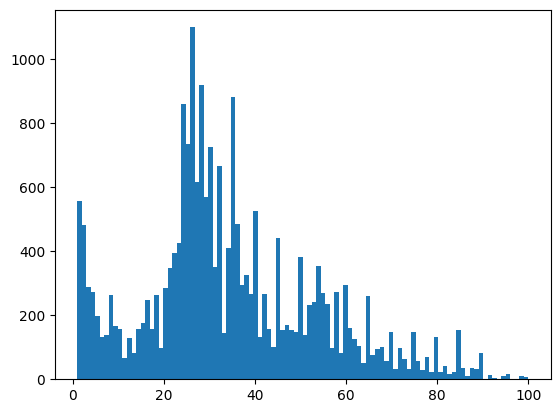

In [5]:
plt.hist(ages, bins=100)
plt.show()

In [6]:
np.unique(ages)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  96,  99, 100])

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(images, ages, genders, test_size = 0.2)
y_cat_train = to_categorical(y_train,101)
y_cat_test = to_categorical(y_test,101) 
z_cat_train = to_categorical(z_train, 2)
z_cat_test = to_categorical(z_test, 2)
del images
del ages

In [2]:
from keras import backend as K
def age_mae(y_true, y_pred):
    true_age = K.sum(y_true * K.arange(0, 101, dtype="float32"), axis=-1)
    pred_age = K.sum(y_pred * K.arange(0, 101, dtype="float32"), axis=-1)
    mae = K.mean(K.abs(true_age - pred_age))
    return mae

In [8]:
# from EfficientNet import EfficientNetV2S
# from keras.layers import Conv2D, Flatten, Activation, Input, Lambda, Dense, BatchNormalization, Dropout, Add, Concatenate, PReLU
# from keras.models import Model, Sequential

# # Define the input tensor for the custom model
# pretrained_model = EfficientNetV2S(input_shape=(96, 96, 3), first_strides=1, include_top=False, weights='imagenet')
# for layer in pretrained_model.layers[:286]:
#     layer.trainable = False
    
# # for layer in pretrained_model.layers:
# #     print(layer.name, layer.trainable)
    
# x = pretrained_model.layers[-2].output
# x = Dropout(0.5)(x)
# x = Conv2D(512, (3, 3))(x)
# x = PReLU()(x)
# x = Dropout(0.5)(x)
# x = Conv2D(256, (3, 3))(x)
# x = PReLU()(x)
# x = Dropout(0.5)(x)
# x = Conv2D(101, (2, 2), name='predictions')(x)
# x = Flatten()(x)
# predictions = Activation('softmax')(x)

# # Create a new model with the modified architecture
# model = Model(inputs=pretrained_model.input, outputs=predictions)
# model.summary()
# age_model = Sequential()
# # Add the preprocessing layer to the Sequential model
# age_model.add(Lambda(lambda x: (x / 255.0 - 0.5) * 2.0, input_shape=(96, 96, 3)))

# # Add the pretrained model to the Sequential model
# age_model.add(model)

# # Compile the model
# age_model.compile(optimizer='adam', loss='mse', metrics=[age_mae])
# # age_model.summary()
# del x 
# del pretrained_model
# del predictions
# del model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 96, 96, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 96, 96, 24)   96          ['stem_conv[0][0]']              
                                                                                              

In [17]:
from deepface import DeepFace
from keras.layers import Lambda, Input, Dense
from keras.models import Model

# Load the Facenet model
pretrained_model = DeepFace.build_model('Facenet')

# Freeze all layers in the base model
for layer in pretrained_model.layers[:341]:
    layer.trainable = False
    
# Remove the last two layers from the model
new_layer_list = pretrained_model.layers[:-2]

# Create a new model with the modified layer list
pretrained_model = Model(inputs=pretrained_model.input, outputs=new_layer_list[-1].output)
pretrained_model.summary()

# for layer in pretrained_model.layers:
#     print(layer.name, layer.trainable)

# Create a new input layer
inputs = Input(shape=(160, 160, 3))
x = Lambda(lambda x: x / 127.5 - 1)(inputs)
x = pretrained_model(x)

# Add a new output layer
predictions_age = Dense(101, activation='softmax', name='age_output')(x)
predictions_gender = Dense(2, activation='softmax', name='gender_output')(x)

# Create a new model with the modified architecture
age_gender_model = Model(inputs=inputs, outputs=[predictions_age, predictions_gender])
age_gender_model.summary()

# Compile the model
age_gender_model.compile(optimizer='adam', loss={'age_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'}, metrics={'age_output': age_mae, 'gender_output': 'accuracy'})
age_gender_model.load_weights('Age_Gender_model_FaceNet.h5')
del x 
del predictions_age
del predictions_gender
del pretrained_model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                            

In [3]:
from deepface import DeepFace
from keras.layers import Lambda, Dense, Input
from keras.models import Model

# Load the Facenet model
pretrained_model = DeepFace.build_model('ArcFace')

# Freeze all layers in the base model
for layer in pretrained_model.layers[:148]:
    layer.trainable = False
    
# Remove the last two layers from the model
new_layer_list = pretrained_model.layers[:-2]

# Create a new model with the modified layer list
pretrained_model = Model(inputs=pretrained_model.input, outputs=new_layer_list[-1].output)
    
# for layer in pretrained_model.layers:
#     print(layer.name, layer.trainable)    

# Create a new input layer
inputs = Input(shape=(112, 112, 3))
x = Lambda(lambda x: (x - 127.5) / 128)(inputs)
x = pretrained_model(x)

# Add a new output layer
predictions_age = Dense(101, activation='softmax', name='age_output')(x)
predictions_gender = Dense(2, activation='softmax', name='gender_output')(x)

# Create a new model with the modified architecture
age_gender_model = Model(inputs=inputs, outputs=[predictions_age, predictions_gender])
age_gender_model.summary()

# Compile the model
age_gender_model.compile(optimizer='adam', loss={'age_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'}, metrics={'age_output': age_mae, 'gender_output': 'accuracy'})
age_gender_model.load_weights('Age_Gender_model.h5')
del x 
del predictions_age
del predictions_gender
del pretrained_model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 112, 112, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 25088)        21317568    ['lambda[0][0]']                 
                                                                                                  
 age_output (Dense)             (None, 101)          2533989     ['model[0][0]']            

In [9]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor= 'age_output_age_mae', 
    patience= 5, 
    mode= 'min'
)

In [10]:
age_gender_model.fit(x_train, [y_cat_train, z_cat_train],
          epochs = 200, 
          verbose = 1,
          validation_data = (x_test, [y_cat_test, z_cat_test]),
          callbacks = [early_stopping])

Epoch 1/200


ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/model_2/conv2d/Relu' defined at (most recent call last):
    File "c:\Users\steve\.conda\envs\global\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\steve\.conda\envs\global\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "c:\Users\steve\.conda\envs\global\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\steve\.conda\envs\global\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\steve\.conda\envs\global\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\steve\.conda\envs\global\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\steve\AppData\Local\Temp\ipykernel_11856\3746790444.py", line 1, in <module>
      age_gender_model.fit(x_train, [y_cat_train, z_cat_train],
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\steve\AppData\Roaming\Python\Python310\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_3/model_2/conv2d/Relu'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/model_2/conv2d/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2446]

In [11]:
#Save model
age_gender_model.save('Age_Gender_model_FaceNet.h5')

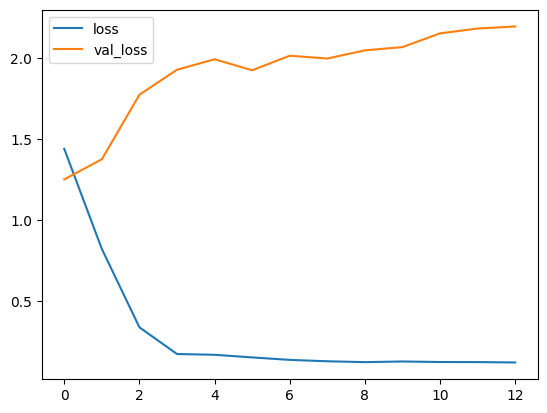

In [16]:
metrics = pd.DataFrame(age_gender_model.history.history)
metrics[['loss','val_loss']].plot()
plt.show()

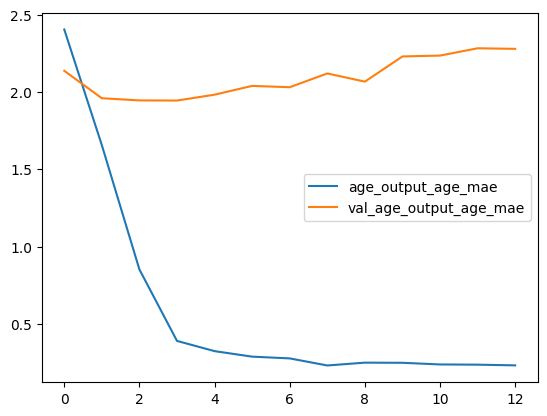

In [18]:
metrics[['age_output_age_mae','val_age_output_age_mae']].plot()
plt.show()

In [19]:
predictions = age_gender_model.predict(x_test)
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions[0] * output_indexes, axis = 1)
mae = 0
 
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = apparent_predictions[i]
    actual = y_test[i]
 
    abs_error = abs(prediction - actual)
 
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]
 
print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

172/172 [==============================] - 27s 157ms/step
mae:  2.279892955759284
instances:  5504


1/1 [==============================] - 4s 4s/step
apparent age:  36
Male


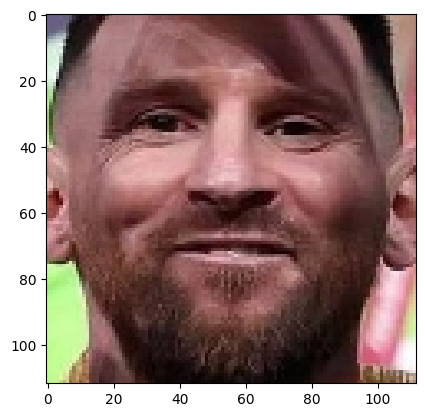

In [5]:
from tensorflow.keras.preprocessing import image
output_indexes = np.array([i for i in range(0, 101)])
genders = ['Male', 'Female']
# img = functions.extract_faces('D:\Program Files (x86)\Python VS Code\Facial Emotion Recognition\Test Image/319332189_5739303202805504_5092169130722191311_n.jpg', target_size = (160, 160), enforce_detection=False, grayscale=False, align=False, detector_backend="mediapipe")
# img = np.squeeze(np.uint8((img[0][0])*255))
# img = cv2.resize(img, (112, 112))
img = cv2.resize(cv2.imread('D:\Program Files (x86)\Python VS Code\Facial Emotion Recognition\Test Image/319332189_5739303202805504_5092169130722191311_1.jpg'), (112, 112))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
test_img = image.img_to_array(img)
test_img = np.expand_dims(test_img, axis = 0)
predictions = age_gender_model.predict(test_img)
apparent_age = np.round(np.sum(predictions[0] * output_indexes, axis = 1))
gender = np.argmax(predictions[1])
print("apparent age: ", int(apparent_age[0]))
print(genders[gender])